In [3]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import fmplib as fmp

In [4]:
#get audio
snd1 = fmp.load_wav('wav/Twinkle1.wav')

In [5]:
#make stft with hanning window (N=4096, H=1024, zp factor = 4)
#plot stft
N = 4096
H = 1024
fs = 22050
X = fmp.stft(snd1, N, H, zp_factor=4)
X = np.log10(1+10*X)

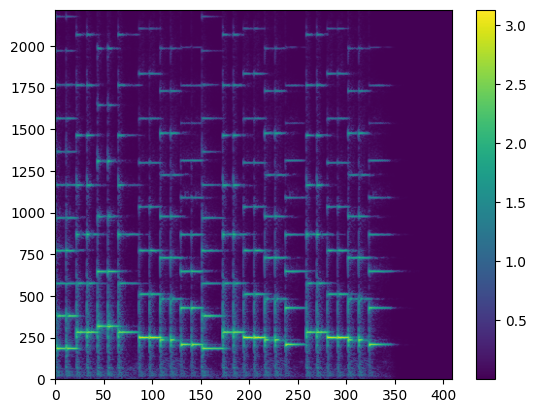

In [6]:
#consider k within k range wanted
k_max = round(N*12000/fs)
k_min = round(N*65/fs) #C2 for now
plt.imshow(abs(X[k_min:k_max+1, :]), origin='lower', aspect='auto')
plt.colorbar()

C:\Users\my537\AppData\Local\Temp\ipykernel_34592\1637498931.py:8: RuntimeWarning: divide by zero encountered in divide
  return abs((abs(stft)-abs(shift_stft))/shift_stft)
C:\Users\my537\AppData\Local\Temp\ipykernel_34592\1637498931.py:8: RuntimeWarning: invalid value encountered in divide
  return abs((abs(stft)-abs(shift_stft))/shift_stft)


[           inf 2.71960753e-01 1.55218364e-01 7.91941870e-02
 7.39295621e-03 5.54616335e-02 6.67152783e-02 3.08455683e-02
 6.60903033e-02 6.85614503e-02 3.48473297e-02 2.23991327e-01
 1.79798736e-01 1.30244117e-01 5.99003111e-03 6.73106899e-02
 4.02471509e-02 6.27075688e-02 7.23545240e-02 3.43828873e-02
 1.17633806e-02 7.76708456e-02 3.27232606e-01 3.67882287e-01
 9.14886807e-02 5.74598238e-02 7.76946909e-02 8.69668087e-02
 9.72181525e-02 1.03213293e-01 9.84245448e-02 9.78666892e-02
 1.49862025e-01 9.62493914e-02 1.46308877e-01 6.21318110e-02
 6.77886398e-02 7.52742310e-02 3.76377984e-02 1.01030979e-01
 8.89084882e-02 6.10107241e-02 1.21807915e-01 9.27117394e-02
 2.25394043e-01 1.55794541e-01 1.94096983e-01 1.19386116e-01
 1.23204856e-01 7.57192420e-02 1.32412406e-01 1.60844226e-01
 1.70881769e-01 2.13901236e-01 2.65475984e-01 1.63089510e-01
 1.73397644e-01 5.66978201e-02 1.00169337e-01 5.42551856e-03
 1.32884894e-01 3.65861059e-02 1.62462732e-01 2.11702444e-01
 1.69337218e-01 3.533039

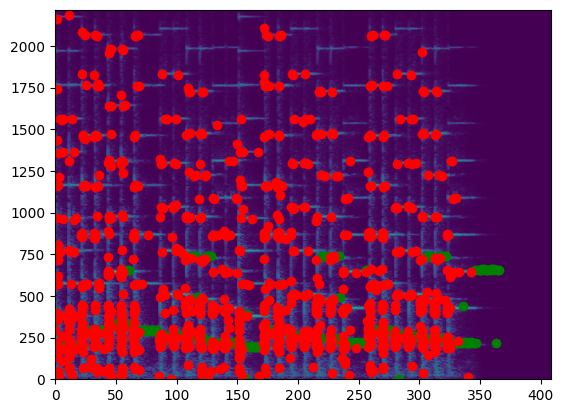

In [9]:
#calculate tonality at k
def tonality(stft):
    return amp_tonality(stft)*peak_tonality(stft, 4)
    pass

def amp_tonality(stft): #take derivative instead or 1 minus this
    shift_stft = np.pad(stft[:, :-1], ((0, 0), (1, 0)), mode='constant', constant_values=0)
    return abs((abs(stft)-abs(shift_stft))/shift_stft)

def peak_tonality(stft, m): #take reciprocal of this
    pad_stft = np.pad(stft, ((m, m), (0, 0)), mode='constant', constant_values=0)
    return (abs(pad_stft[:len(stft),:])-abs(pad_stft[2*m:,:]))/abs(stft)

def find_intersection(matrix1, matrix2):
    set1 = set(map(tuple, matrix1))
    set2 = set(map(tuple, matrix2))
    return np.array(list(set1 & set2)).T

T = tonality(X)
amp_stft = amp_tonality(X)

#get T threshold and area peaks
temp_peaks = np.array(np.where(abs(X) > .5*np.max(abs(X))))
# temp_peaks = np.array(np.where((T > .7) | (abs(X) > .5*np.max(abs(X)))))
area_peaks = fmp.find_area_peaks(abs(X), 16, 4).T #arbitrary
area_peaks[[0, 1]] = area_peaks[[1, 0]] #same 'values' at 0 and 1
T_peaks = find_intersection(area_peaks.T, temp_peaks.T)

#get k threshold
thresh_i = np.where((T_peaks[0] >= k_min) & (T_peaks[0] <= k_max))
T_peaks = T_peaks[:, thresh_i[0]]

song = np.argmax(abs(X), axis=0)
song = song[np.where(song < k_max)]
print(amp_stft[song, np.arange(len(song))])

plt.imshow(abs(X[k_min:k_max+1, :]), origin='lower', aspect='auto')
plt.plot(np.arange(len(song)), song, 'go')
plt.plot(T_peaks[1], T_peaks[0]-k_min, 'ro')


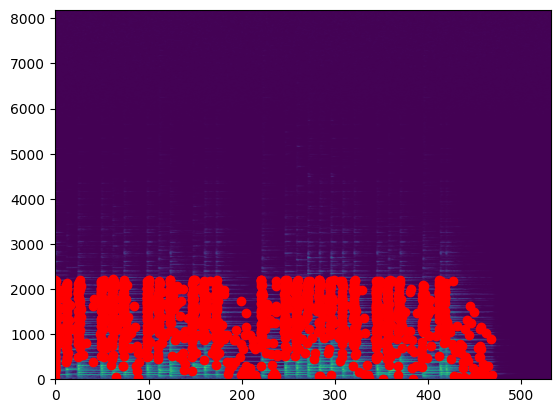

In [255]:
sal_stft = X**.25
def calc_spectral_sal(t_peaks, stft):
    #also do local max instead
    vals = stft[t_peaks[0], t_peaks[1]] + stft[2*t_peaks[0], t_peaks[1]] + stft[3*t_peaks[0], t_peaks[1]]
    threshold = .1**25*np.max(vals) #change later?
    return t_peaks.T[vals > threshold]
    pass

spectral_sal = calc_spectral_sal(T_peaks, sal_stft).T #same dim as T_peaks
plt.imshow(abs(X), origin='lower', aspect='auto')
plt.plot(spectral_sal[1], spectral_sal[0]-k_min, 'ro')

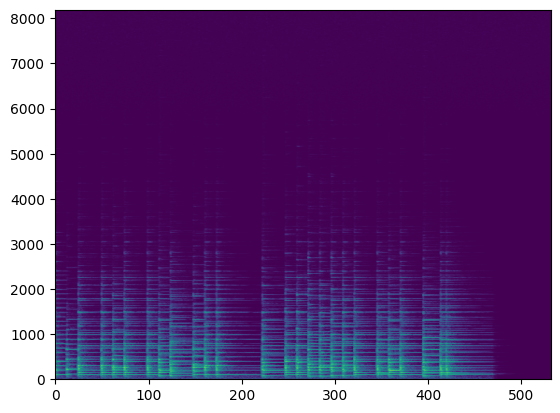

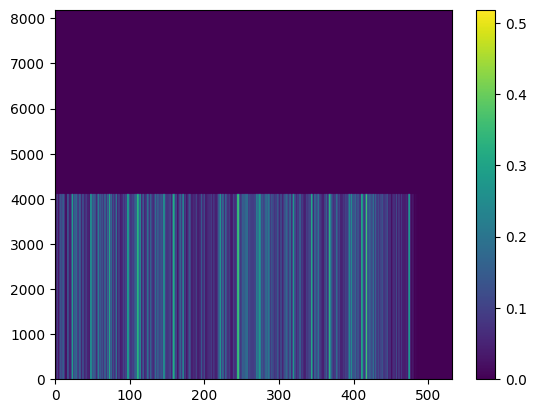

In [264]:
import scipy.signal as signal

#some pre-whitening
def smoothing(x, alpha):
    smooth_x = np.zeros(len(x))
    smooth_x[0] = x[0]
    for n in range(1, len(x)): #smooth one direction
        smooth_x[n] = alpha*x[n] + (1-alpha)*smooth_x[n-1]

    for n in range(len(x)-2, -1, -1): #smooth other direction
        smooth_x[n] = alpha*smooth_x[n] + (1-alpha)*smooth_x[n+1]

    return smooth_x

def make_MCACF(shape, c):
    W_c_1d = np.arange(shape[0]).astype(float) #has all k values
    k_c = k_min*2**c

    W_c_1d[:round(k_c/4+.5)] = 0
    W_c_1d[round(k_c/4+.5):k_c] = 4/(3*k_c)*np.arange(round(k_c/4+.5), k_c)-1/3
    W_c_1d[k_c: 2*k_c+1] = 1
    W_c_1d[2*k_c+1:20*k_c] = -1/(18*k_c)*np.arange(2*k_c+1, 20*k_c)+10/9
    W_c_1d[20*k_c:] = 0
    # W_c = np.repeat(W_c_1d[:, np.newaxis], shape[1], axis=1)
    return W_c_1d[:, np.newaxis]

def make_W_c(num):
    W_c = []
    for c in range(num):
        temp_prime = make_MCACF(X.shape, c)
        # W_c.append(temp_prime/sum(temp_prime[:, 0])) #different sum?
        W_c.append(temp_prime/sum(temp_prime)) #different sum? should this be 2d?
    return W_c

def make_e(x, p):
    L = len(x)
    new_x = np.pad(x, (1, p-1))
    S = np.hstack([np.roll(new_x, i).reshape(-1, 1) for i in range(p)])
    S_cov = S[p-1:L-1, :]
    s_cov = x[p:]
    R_hat_p = (S_cov.conj().T) @ S_cov
    r_hat_p = (S_cov.conj().T) @ s_cov
    alpha_p = np.linalg.pinv(R_hat_p) @ r_hat_p

    a = np.pad(-alpha_p, (1, 0), 'constant', constant_values=(1, 1))
    e_p = s_cov - S_cov@alpha_p
    epsilon = np.abs(e_p.conj().T @ e_p)
    G = np.sqrt(epsilon)

    w, h = signal.freqz(b=G, a=a, worN=N)
    return h

def make_E(full_x, p, shape):
    E = np.zeros(shape)
    ks = np.arange(N)
    hann = np.hanning(N)
    for n in range(shape[1]):
        if n%20==0:
            print(n/shape[1])
        try:
            temp = full_x[H*n: H*n+N]*hann
        except:
            temp = np.pad(full_x[H*n:], (0, N-len(full_x)+H*n))*hann
        temp = np.pad(temp, (0, shape[0]-N))
        coeffs = make_e(temp, p)
        log_space_coeffs = np.interp(10**ks, ks, coeffs)
        smoothed_coeffs = smoothing(log_space_coeffs, 20/N)
        E[:N, n] = np.interp(np.log10(ks), ks, smoothed_coeffs)
    return E
    

# p = len(spectral_sal[0])
# E = make_E(snd1, p, X.shape)

temp_e = np.copy(E)
temp_e[temp_e == 0] = .00001
X_w_prime = X/temp_e
X_w1 = X_w_prime * np.sqrt(np.sum(X[:k_max, :]**2)/np.sum(X_w_prime[:k_max, :]**2)) #sqrt is a number

W_c = make_W_c(5)
plt.figure()
plt.imshow(abs(X), origin='lower', aspect='auto')
plt.figure()
plt.imshow(abs(E), origin='lower', aspect='auto')
plt.colorbar()

In [257]:
def make_A_c(X, W_c, N, H):
    A_c = []
    for c in range(len(W_c)):
        val = np.sqrt(N*X**2)*W_c[c]
        # A_c.append(fmp.istft(val, H))
        A_c.append(np.fft.ifft2(val))
    return A_c

def find_A_peaks(a_c, c):
    if a_c is None:
        return None
    temp_peaks = fmp.find_area_peaks(abs(a_c), 8, 8) #x, y
    temp_peaks[:, [0, 1]] = temp_peaks[:, [1, 0]] #y, x
    thresh = .001*np.max(a_c[1:, :])
    temp_peaks = temp_peaks[a_c[temp_peaks[:, 0], temp_peaks[:, 1]] > thresh]
    m_max = np.max(temp_peaks[:, 0])
    range_i = np.where((2**(-c)*m_max >= temp_peaks[:, 0]) & (2**(-c-1)*m_max <= temp_peaks[:, 0]))
    range_peaks = temp_peaks[range_i[0]]
    return range_peaks.T

A_c = make_A_c(X_w1, W_c, N, H)

band_thresh = .3*np.max([A_c[0][1:, :], A_c[1][1:, :], A_c[2][1:, :], A_c[3][1:, :], A_c[4][1:, :]])
for c in range(5):
    if np.max(A_c[c][1:, :]) < band_thresh:
        A_c[c] = None

# plt.plot(abs(A_c[2][:, 200]))
A_peaks = [find_A_peaks(A_c[c], c) for c in range(5)]
# A_peaks = combine_A_peaks(A_peaks_prime)
#black box of finding official A_peaks

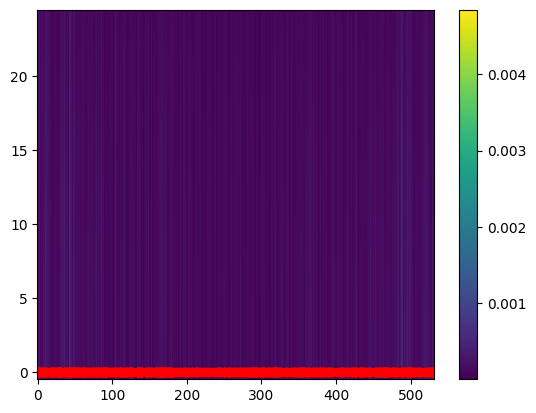

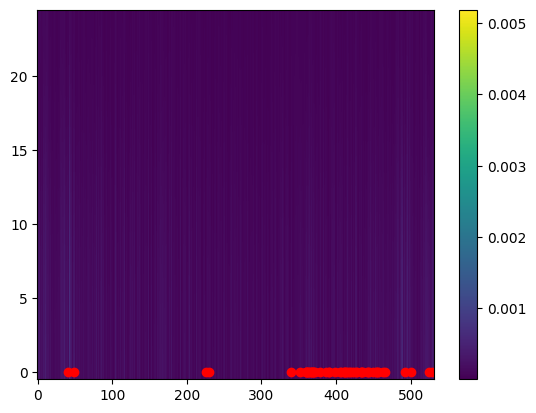

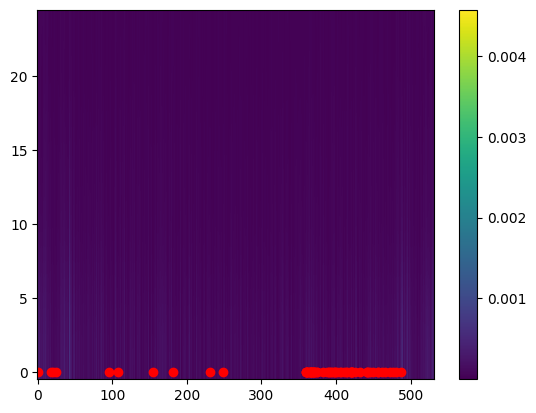

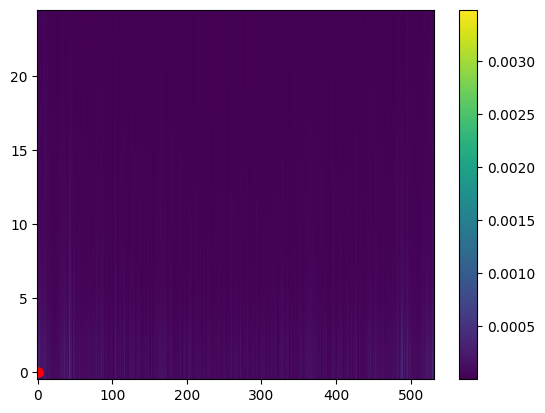

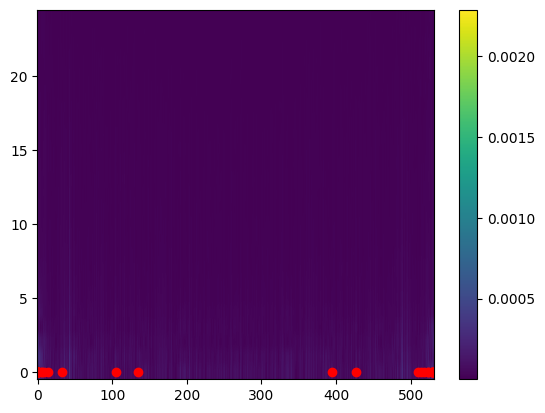

In [279]:
def calc_a_c_sal(a_peaks, a_c):
    #also do local max instead
    if a_c is None:
        return None
    a_sal = np.copy(a_peaks)
    for m in range(len(a_peaks[0])):
        temp_m = a_peaks[0][m]
        if temp_m > .66 * a_c.shape[0]:
            temp_m //= 3
        elif temp_m > .33 * a_c.shape[0]:
            temp_m //= 2
        a_sal[0, m] = abs(a_c[temp_m, a_peaks[1][m]]) + abs(a_c[2*temp_m, a_peaks[1][m]]) + abs(a_c[3*temp_m, a_peaks[1][m]])
    return a_sal

A_c_sal = [calc_a_c_sal(A_peaks[c], A_c[c]) for c in range(5)]
for c in range(5):
    plt.figure()
    plt.imshow(abs(A_c[c][:25, :]), origin='lower', aspect='auto')
    plt.plot(A_c_sal[c][1], A_c_sal[c][0], 'ro')
    plt.colorbar()

In [259]:
def make_Q_a_c(a_peaks):
    if a_peaks is None:
        return None
    Q_a = np.zeros(a_peaks.shape)
    freq = fs/a_peaks[0]
    Q_a[0] = np.round(69+12*np.log2(freq/(440)))
    Q_a[1] = a_peaks[1]*1
    return Q_a

def make_Q_x(x_peaks):
    Q_x = np.zeros(x_peaks.shape)
    Q_x[0] = k_to_pitch(x_peaks[0])
    Q_x[1] = x_peaks[1]*1
    return Q_x

def k_to_pitch(k_vals):
    freqs = k_vals*fs/N
    return np.round(fmp.freq_to_pitch(freqs))

Q_x = make_Q_x(spectral_sal)
Q_a = [make_Q_a_c(A_peaks[c]) for c in range(5)]

In [260]:
def make_Q_sal(q_x, peaks, sal_stft):
    #along each time bin (np.where to isolate n values):
    #turn this n into something of length 12000
    #for items with only one MIDI value, assign S_q(q, n) to relevant sal_stft(k, n)
    #for k's that overlap into one MIDI value, assign S_q(k, n) to the max 
    #return something of size of (wanted MIDI values, n)
    Q_sal = np.zeros((127, sal_stft.shape[1]))
    for n in np.unique(peaks[1]):
        found_q = q_x[0][np.where(q_x[1] == n)]
        for q in found_q:
            #np where
            found_k = peaks[0][np.where((q_x[1] == n) & (q_x[0] == q))]
            if len(found_k) > 1:
                pass #assign S_q(k, n) to the max salience
                best_k = found_k[np.argmax(sal_stft[found_k, n])]
                Q_sal[int(q), n] = abs(sal_stft[best_k, n])
            else:
                pass #assign S_q(q, n) to relevant sal_stft(k, n)
                Q_sal[int(q), n] = abs(sal_stft[found_k[0], n])
            
    return Q_sal

def make_Q_a_sal(Q_a, peaks, A_c): #autocorrleation
    q_sals = []
    for c in range(len(Q_a)):
        q_sals.append(make_Q_sal(Q_a[c], peaks[c], A_c[c]))
    return np.maximum.reduce(q_sals)

S_Q_x = make_Q_sal(Q_x, spectral_sal, sal_stft)
S_Q_a = make_Q_a_sal(Q_a, A_peaks, A_c) #wrong stft
S_Q = S_Q_x*S_Q_a

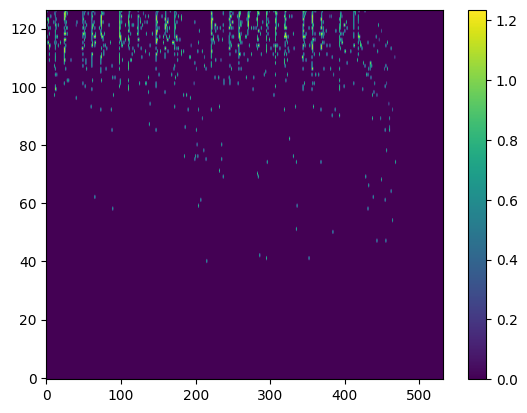

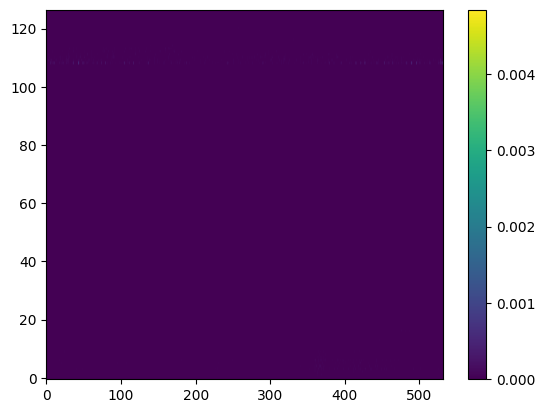

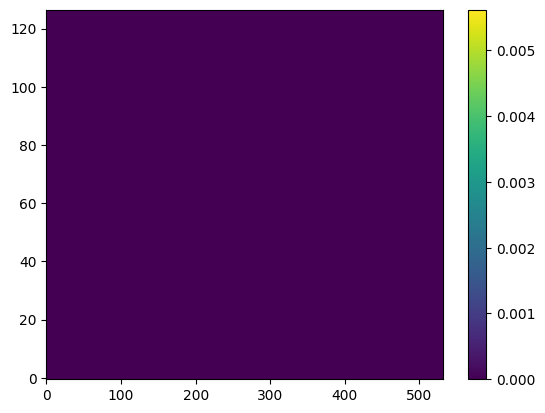

In [261]:
plt.figure()
plt.imshow(S_Q_x, aspect='auto', origin='lower')
plt.colorbar()

plt.figure()
plt.imshow(S_Q_a, aspect='auto', origin='lower')
plt.colorbar()

plt.figure()
plt.imshow(S_Q, aspect='auto', origin='lower')
plt.colorbar()